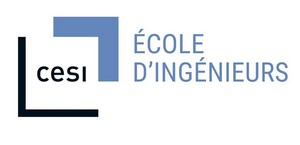

<h1 align='center'>Projet Leyenda - Livrable 1 - Classification binaire</h1>
<h3 align='center'>Youssef AYARI, Matthieu DECLERCQ, Thomas PETAIN, Julien BARON, Jean-Baptiste CASTELLANI</h1>

## Sommaire

* [1. Introduction](#chapter1)
    * [1.1 Rappel du besoin](#section_1_1)
    * [1.2 Expression du besoin](#section_1_2)
    * [1.3 Contraintes](#section_1_3)
* [2. Configuration de l'environnement](#chapter2)
    * [2.1 Import des librairies Python](#section_2_1)
    * [2.2 Utilisation du GPU](#section_2_2)
* [3. Préparation du dataset](#chapter3)
    * [3.1 Création d'un jeu d'entraînement et de test](#section_3_1)
    * [3.2 Augmentation des performances du dataset](#section_3_2)
* [4.Création du modèle](#chapiter4)
    * [4.1 Convolutional neural network](#section_4_1)
    * [4.2 Techniques de régularisation](#section_4_2)
    * [4.3 Implémentation des techniques de régularisation](#section_4_3)
    * [4.4 Implémentation du CNN](#section_4_4)
* [5. Mesure de la performance](#chapter5)
    * [5.1 Matrice de confusion](#section_5_1)
    * [5.2 Précision, Recall, F1 Score](#section_5_2)
    * [5.3 Courbe ROC](#section_5_3)
* [6. Classification du modèle](#chapter6)
    * [6.1 Sauvegarde du modèle](#section_6_1)
    * [6.2 Sauvegarde des résultats de classification du modèle](#section_6_2)
* [7. Conclusion](#chapter7)

## 1. Introduction <a class="anchor" id="chapter1"></a>

### 1.1 Rappel du besoin <a class="anchor" id="section_1_1"></a>

<div style="text-align: justify">Dans le cadre de ce projet, l'entreprise TouNum, spécialisée dans la numérisation de documents, souhaite étendre leur gamme de services pour inclure des outils de Machine Learning. En effet, leur clientèle possède une grande quantité de données à numériser au format papier. Dans le but de rester compétitif dans ce secteur d’activité, l’entreprise décide d’innover et de proposer un service de catégorisation qui serait plus que valorisable. Afin de mener à bien cette tâche, des spécialistes en Data Science du CESI ont été contactés.
<p>

L’objectif de cette première partie est d’automatiser la sélection des photos pour l’annotation. Pour ce faire, nous nous basons sur les réseaux de neurones afin de filtrer les images qui ne sont pas des photos dans le dataset de départ.<div>

### 1.2 Expression du besoin <a class="anchor" id="section_1_2"></a>

<div style="text-align: justify">Afin d’apporter une réponse adaptée à la problématique énoncée dans l’introduction de ce notebook. Il nous apparaît intéressant d’analyser le besoin de l’utilisateur final. Cette démarche a pour but de 
donner un point de vue global des attendus auxquels la solution doit répondre. Ce qui nous 
donnera une ligne directrice à suivre tout au long de ce notebook. Afin, de donner un aperçu plus clair sur la marche à suivre pour répondre au besoin exprimé, nous pouvons nous aider du diagramme bête à cornes ci-dessous.</div>

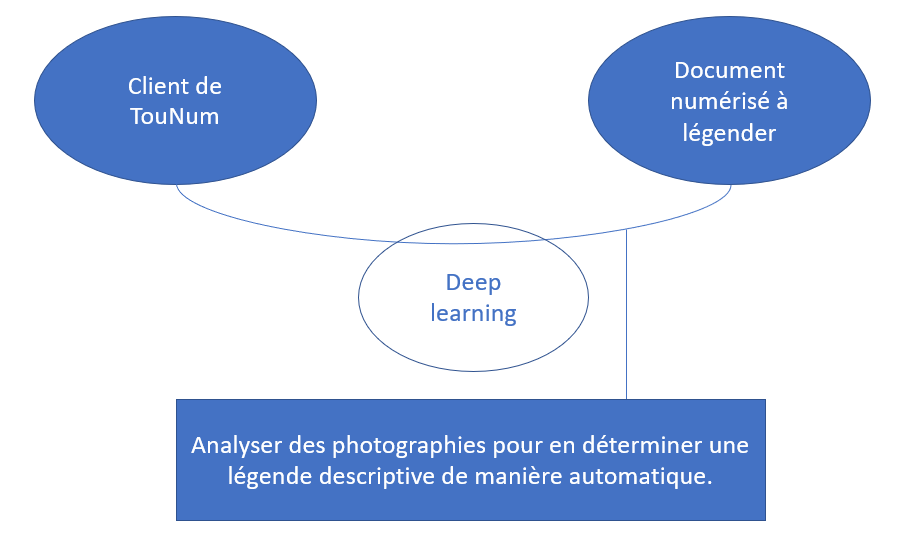
<center><em>Diagrame Bête à cornes</em></center>

### 1.3 Contraintes <a class="anchor" id="section_1_3"></a>

<div style="text-align: justify">Cette première partie comporte plusieurs contraintes liées à la vision par ordinateur. En effet, nous devons être en capacité de déterminer si les images sont des photos sans tenir compte de l’orientation, de la luminosité, ou la variation d’échelle de celles-ci. De plus, nous devrons extraire les features qui nous permettrons de distinguer les différences entre les types d’images qui composent le dataset.</div>  

## 2. Configuration de l'environnement <a class="anchor" id="chapter2"></a>

<div style="text-align: justify">Cette deuxième partie traite des différents modules que nous avons dû importer dans ce notebook pour pouvoir mener à bien ce projet. Nous reviendrons par conséquent sur les deux étapes cruciales qui sont l'import des librairies Python et l'installation du GPU comme support de calcul pour les différentes cellules du notebook.</div>

### 2.1 Import des librairies Python <a class="anchor" id="section_2_1"></a>

Dans le cadre de ce premier livrable, nous avons décidé d’importer plusieurs librairies Python que nous allons présenter :
<ul>
    <li style="text-align: justify"><strong>TensorFlow</strong> : est un outil open source d'apprentissage automatique développé par Google. Il est l'un des outils les plus utilisés en IA dans le domaine de l'apprentissage machine. Celui-ci contient de nombreuses implémentations de blocs nécessaire à la construction de réseaux de neurones couramment utilisés tels que des couches, des fonctions d'activation, des optimiseurs et une multitude d'outils pour faciliter le travail avec des images ou des textes afin de simplifier le codage nécessaire à l'écriture de code de réseau de neurones profond. <strong>Keras</strong> est l’API haut niveau s’exécutant sur la plateforme d’apprentissage automatique Tensorflow. Elle permet de faciliter la création et l’entraînement des modèles de deep learning.</li><br>
    <li style style="text-align: justify"><strong>NumPy</strong>: est une bibliothèque qui ajoute un support pour les tableaux et matrices multidimensionnels de grande taille, ainsi qu'une large collection de fonctions mathématiques de haut niveau pour opérer sur ces tableaux. Ceci nous permettra de travailler avec des images sous forme de matrice.</li><br>
    <li style style="text-align: justify"><strong>Scikit-learn</strong>: est une bibliothèque d'apprentissage automatique pour le langage de programmation Python. Elle propose divers algorithmes de classification, de régression et de regroupement. Dans le cadre de ce notebook nous l’utilisons pour valider les résultats de notre modèle.</li><br>
    <li style style="text-align: justify"><strong>Matplotlib</strong> : est une bibliothèque du langage de programmation Python destinée à tracer et visualiser des données sous forme de graphiques.</li>
    
</ul>

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K

from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score

### 2.2 Utilisation du GPU <a class="anchor" id="section_2_2"></a>

<div style="text-align: justify">Dans l'optique d’avoir de meilleures performances tout au long de ce projet notamment durant l’entraînement du modèle, nous avons décidé de faire passer le traitement des données par le GPU. Pour ce faire, la ligne ci-dessous nous indique si le système détecte un GPU qui peut être utilisé. (Seules les cartes Nvdia avec Cuda installé sont reconnues par Tensorflow).<div>

In [14]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 3. Préparation du dataset <a class="anchor" id="chapter3"></a>

Nous chargeons en mémoire les différentes variables utiles au modèle telles que la taille, ou le nombre d'images par batch. Cette segmentation du dataset en batch permet à la machine qui exécute le notebook de ne pas saturer sa mémoire. 

In [15]:
data_dir = pathlib.Path("Class")
image_h = 180
image_w = 180
batch_s = 32

### 3.1 Création des jeux d'entrainement et de test <a class="anchor" id="section_3_1"></a>

<div style="text-align: justify">Pour préparer le jeu de données, nous le séparons en deux sous-ensembles homogènes afin d'éviter la sous-représentation de classe. Le premier sous-ensemble dit d'entraînement permettra au modèle d'ajuster ses poids et par conséquent améliorer sa classification. Le second nous permet d'évaluer la classification du modèle. C'est sur ce jeu de données qu'on se base pour le calcul de la précision du modèle.<div>   

In [16]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="training",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  label_mode = "binary"
)
# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="validation",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  label_mode = "binary"
)

Found 41405 files belonging to 2 classes.
Using 33124 files for training.
Found 41405 files belonging to 2 classes.
Using 8281 files for validation.


Le code ci-dessous permet d'afficher les classes composant le Dataset.

In [17]:
class_names = train_set.class_names
print(class_names)

['Autre', 'Photo']


### 3.2 Augmentation des performances du dataset <a class="anchor" id="section_3_2"></a>

Afin d'améliorer les performances du dataset nous pouvons mettre en place différentes méthodes :
- `Dataset.cache()`: Cette fonction nous permettra de garder les données dans la mémoire cache. En effet, notre modèle doit repasser plusieurs fois sur les données d'entraînement à chaque epoch. De cette façon, le rechargement des données est grandement réduit entre chaque epoch. 
- `Dataset.prefetch()`: Nous permet de paralléliser le traitement des batchs par le modèle. Pour ce faire, lors de l'entraînement/évaluation du batch en cours nous commençons le prétraitement du batch suivant.  

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

## 4. Création du Modèle <a class="anchor" id="chapiter4"></a>

Après avoir mis en place l'environnement et préparé notre dataset, nous pouvons commencer à nous pencher sur le modèle. Cette partie se concentre par conséquent sur la justification et la mise en oeuvre du modèle choisi.

### 4.1 Convolutional neural network <a class="anchor" id="section_4_1"></a>

<div style = "text-align: justify">Le <strong>convolutional neural network</strong> (CNN) ou réseau neuronal convolutif est un type réseau de neurones artificiels feed-forward. Son fonctionnement s'inspire de processus biologiques, qui consistent en un empilage multicouche de perceptrons, dont le but est de prétraiter de petites quantités d'informations. Les réseaux neuronaux convolutifs ont de larges applications dans la reconnaissance d'image et vidéo, les systèmes de recommandation et le traitement du langage naturel.
</div>
<br>
<div style = "text-align: justify">Nous avons choisi ce modèle car il répond aux contraintes que nous avons identifiées précédemment dans l'introduction. En effet, celui-ci nous permet d'extraire des features de manière automatique en appliquant des opérations de filtrage par convolution. Pour ce faire, on définit la taille de la matrice de convolution et le nombre de filtres que l'on veut lui appliquer. La matrice, qui représente la feature, se déplace progressivement de la gauche vers la droite. Les résultats du calcul de convolution sont pondérés par la fonction d'activation Relu. Ce processus est décrit par le schéma ci-dessous.</div>

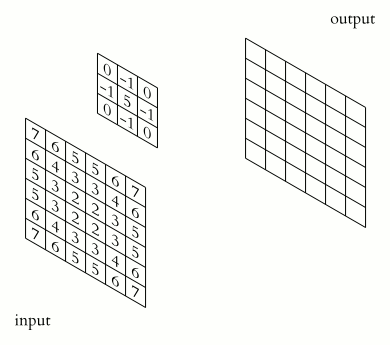
<center><em>Schéma du principe de convolution</em></center>
<br>
<div style = "text-align: justify">Pour trouver de nouvelles features nous devons réduire la taille de l'image. Pour ce faire nous utilisons la méthode de MaxPooling. Elle consiste à regrouper et à sélectionner la valeur la plus haute de la feature map comme le montre ce schéma ci-dessous.</div>

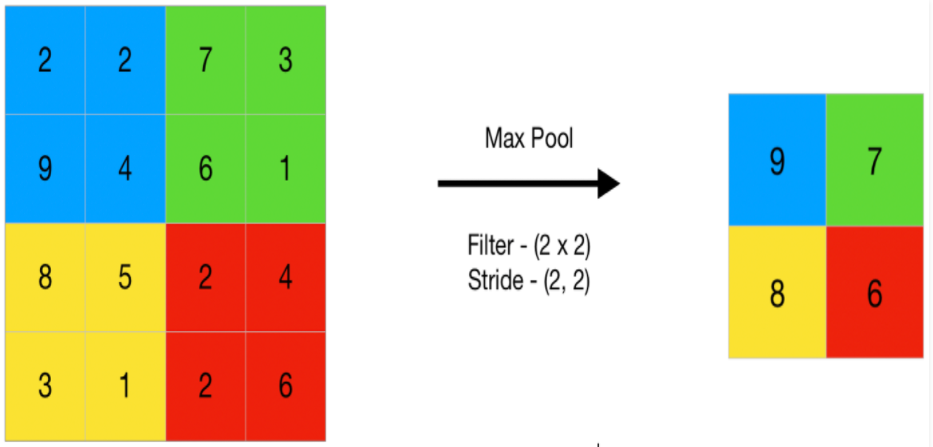
<center><em>Schéma de la méthode de MaxPooling</em></center>

### 4.2 Techniques de régularisation <a class="anchor" id="section_4_2"></a>

<div style = "text-align: justify">Les techniques de régularisation sont les techniques visant à réduire le surapprentissage. L’objectif est d’éviter que le réseau de neurones mémorise le jeu de données en s’ajustant de façon non réfléchie sur les particularités du jeu d’entraînement. Il s’agit globalement de réduire les degrés de liberté du réseau de neurones.
Dans la création de notre modèle, nous verrons que nous avons mis en place 3 de ces techniques.</div>

-	**L’augmentation des données** : "data augmentation" en anglais. Nous savons que le plus important lors de l'entraînement d'un réseau de neurones, ce sont les données. Notre dataset est grand mais pour éviter de faire du surapprentissage, nous avons décidé de l'étoffer. Pour cela, nous sommes partis de notre dataset d'entraînement et nous avons apportés des légères modifications à chacune de nos images (modification de l'angle et zoom sur l'image). Cette technique est très efficace car les réseaux de neurones sont très gourmands en données.


-	**La technique de dropout** : Le dropout est une méthode de régularisation permettant d’éviter le surapprentissage du modèle. Pour ce faire, lors de l’entraînement un certain nombre de sorties de couche est ignoré de manière aléatoire. Cela a pour effet de faire ressembler la couche et d'être traitée comme une couche avec un nombre de nœuds et une connectivité différente par rapport à la couche précédente. Comme le montre le schéma ci-dessous :

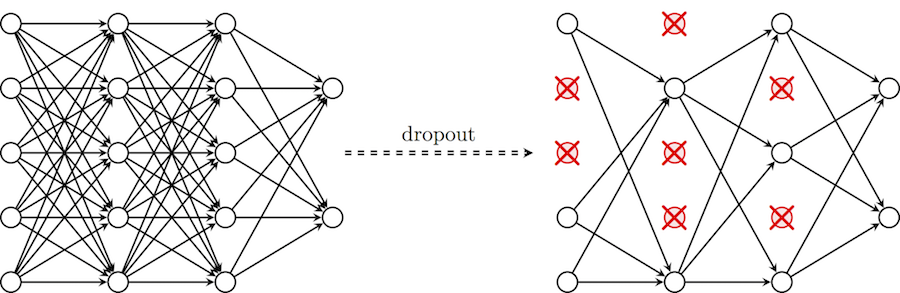
<center><em>Schéma de la méthode de Dropout</em></center>

-	**Early-stopping** : Un problème auquel nous sommes confrontés lors de l'entraînement d'un réseau de neurones, c'est le choix du nombre d'epochs à exécuter pour avoir le réseau le plus performant. En effet, un trop grand nombre d'epochs pourrait mener à un surapprentissage, à contrario, un nombre trop faible entraînera un sous-apprentissage. La technique du Early-stopping nous permettra d'arrêter notre apprentissage lorsque le modèle ne s'améliorera plus. Pour cela, nous avons utilisé la fonction "EarlyStopping" de Keras. 

### 4.3 Implémentation des techniques de régularisation <a class="anchor" id="section_4_3"></a>

#### 4.3.1 Augmentation de données

In [19]:
#Fonction s'occupant de la data augmentation, ajoutant au dataset d'entrainement des images légèrements modifiées par leur orientation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(image_h, 
                                                              image_w,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

#### 4.3.2 Visualisation des données <a class="anchor" id="section_3_4"></a>

Nous affichons un échantillon des données du dataset transformé dans le but de nous donner une meilleure idée des images qui le compose. 

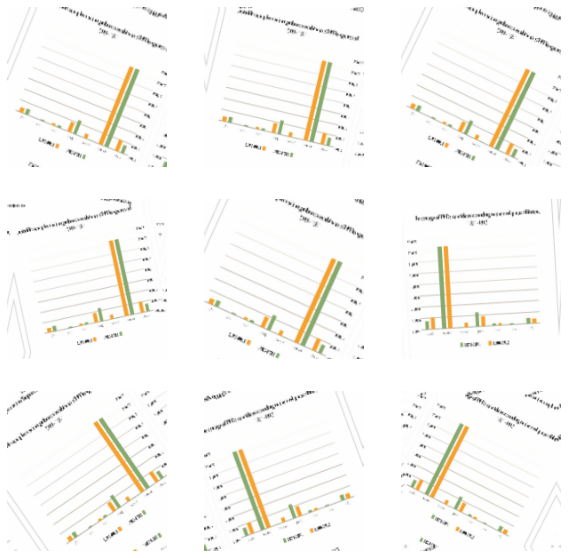

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_set.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### 4.4 Implémentation du CNN <a class="anchor" id="section_4_4"></a>

<div style = "text-align: justify">Dans cette partie, nous allons voir de quelle manière nous avons implémenté notre CNN. Nous verrons de quelle manière nos paramètres ont été définis pour obtenir un modèle performant et comment les techniques de régularisation (dropout et earlystopping) ont été intégrées.</div>

#### 4.4.1 Fine tuning <a class="anchor" id="chapiter_5"></a>

<div style = "text-align: justify">Pour créer notre réseau de neurones convolutifs, nous avons besoin de déterminer nos paramètres optimaux (hyperparamètres) pour obtenir un modèle performant. Or, tester manuellement des combinaisons de paramètres prend énormément de temps. Afin d'être plus efficace, nous avons décidé de réaliser un <strong>fine tuning</strong>.
    <br>
Etant donné que nous avons travaillé exclusivement avec Keras jusqu'à présent, nous avons recherché les solutions proposées par cette API pour réaliser un fine tuning. C'est de cette manière que nous avons découvert <strong>KerasTuner</strong>, un framework permettant de définir facilement des hyperparamètres. 

Dans un premier temps, nous avons déterminé les paramètres les plus influents sur l'apprentissage de notre modèle, les voici : 
    <ul>
        <li>Le nombre de couches de convolution</li>
        <li>La fonction d'activation de notre couche "dense" (dernière couche de notre modèle)</li>
        <li>La fonction de perte</li>
        <li>Le nombre de filtres de chaque couche de convolution</li>
        <li>La taille de chaque kernel de convolution (le kernel est la matrice qui servira de filtre à appliquer sur chaque image lors de l'étape de convolution)</li>
        <li>La dimension de notre sortie de couche dense (units)</li>
    </ul>
    
Pour imager nos propos, voici une capture d'écran du code correspondant à ce fine tuning : 
</div>

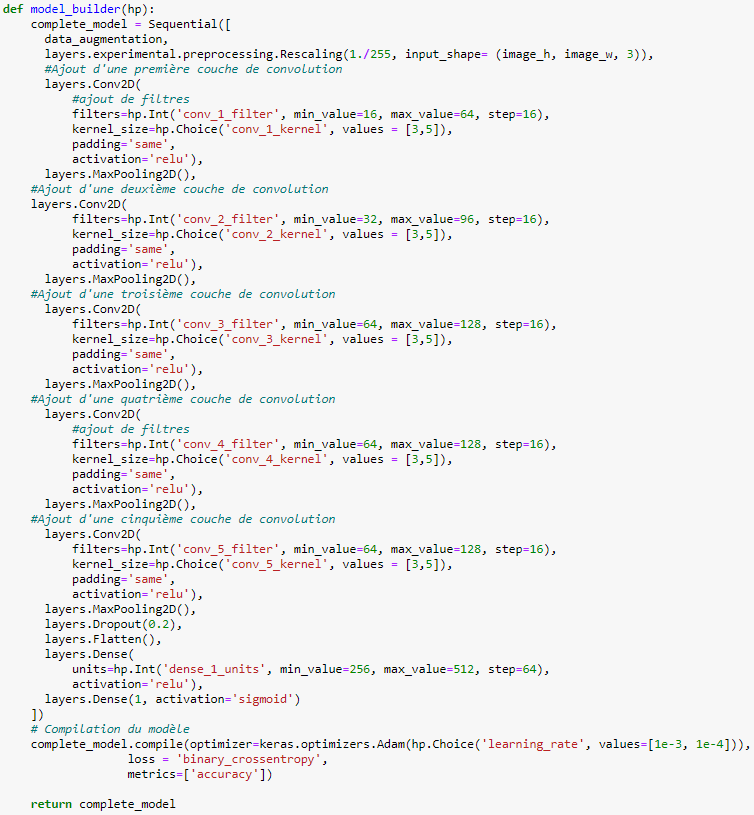
<center><em>Capture d'écran du code correspondant au fine tuning</em></center>

<div style = "text-align: justify">Dans un second temps, nous avons cherché des moyens de déterminer les valeurs optimales des paramètres influents. <br>
    <ul>
        <li><strong>Le nombre de couches de convolution</strong></li>
Pour cela, nous avons cherché dans la littérature et après plusieurs recherches nous avons remarqué que les modèles de classification binaire étaient souvent formés de <strong>5 couches</strong> de convolution.
        <li><strong>La fonction d'activation</strong> de notre couche "dense" (dernière couche de notre modèle)</li>
La fonction que nous avons retenu est la fonction <strong>sigmoïde</strong>. En effet, cette fonction nous retourne une valeur de prédiction entre 0 et 1, ce qui correspond parfaitement à notre problème de classification binaire. 
        <li><strong>La fonction de perte</strong></li>
Pour cette fonction, nous avons gardé la même réflexion. Vu que nous sommes dans un problème de classification bianire, nous avons choisi la fonction <strong>BinaryCrossentropy</strong>.
        <li><strong>Le nombre de filtres de chaque couche de convolution</strong></li>
        <li><strong>La taille de chaque kernel de convolution</strong>)</li>
        <li><strong>La dimension de notre sortie de couche dense (units)</strong></li>
Pour ces trois derniers points, nous avons utilisé des fonctions de KerasTuner qui nous permettent de mettre une fourchette de valeurs pour chacun de ces paramètres et avec un pas défini, l'API va tester plusieurs combinaisons dans cette tranche de valeurs. 
    </ul>
</div>

<div style = "text-align: justify">Ensuite, nous appelons la fonction <strong>RandomSearch</strong> qui va essayer de déterminer le meilleur modèle en fonction des valeurs qu'on lui a indiqué.</div>

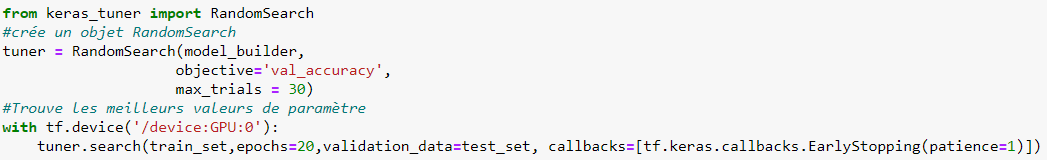
<center><em>Capture d'écran de l'implémentation de la méthode RandomSearch</em></center>

<div style = "text-align: justify">Ce fine tuning demande beaucoup de ressources et de temps, c'est pourquoi nous avons fait un notebook à part. Voici les résultats que nous avons obtenus et que nous utiliserons dans notre modèle final.</div> 

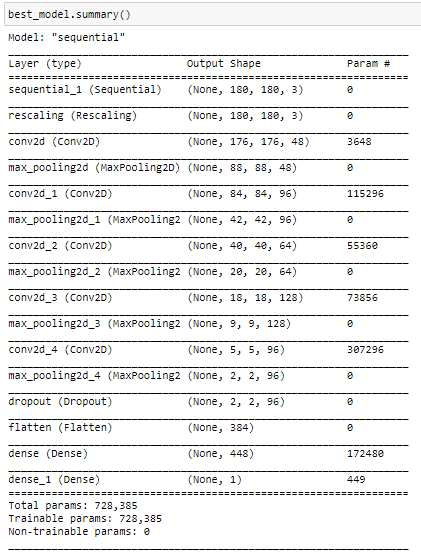

#### 4.4.2 Création du modèle final

En partant des résultats obtenus suite au fine tuning, nous pouvons créer notre modèle.

Voici un schéma représentant l'architecture de notre réseau de neurones :
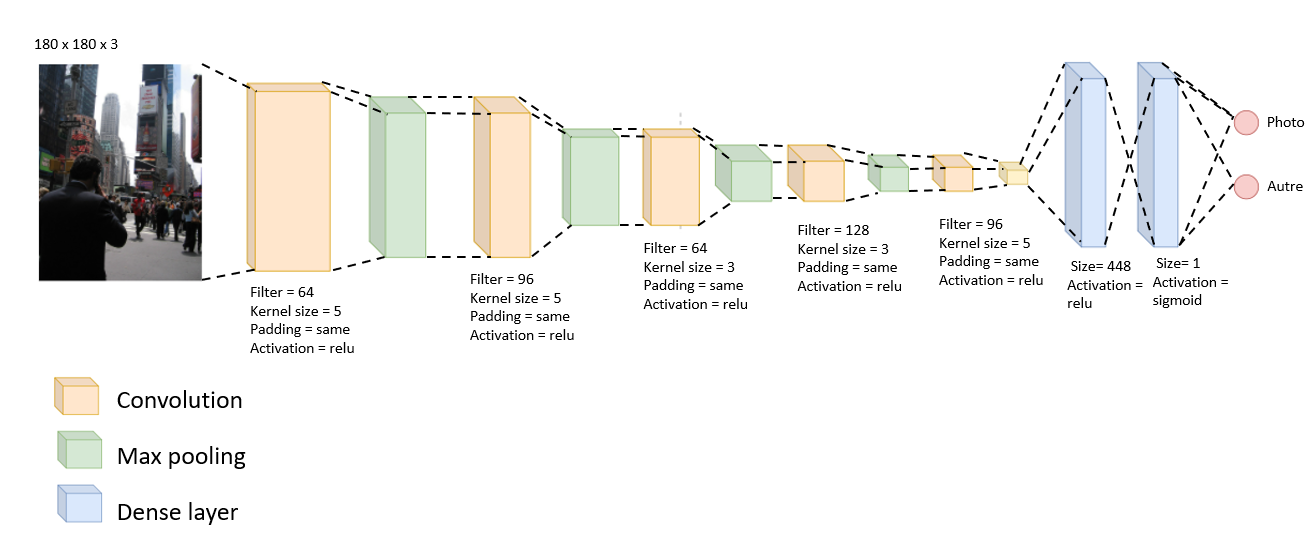
<center><em>Schéma de l'architecture de notre réseau de neurones</em></center>

In [21]:
#Le modèle
complete_model = Sequential([
    #Rajout de la data augmentation.
    data_augmentation,
    #Normalisation du jeu de données.
    layers.experimental.preprocessing.Rescaling(1./255),
    #Opération de convolution. 
    layers.Conv2D(48,               #Nombre de filtres appliqués.
                  5,                #Taille de la matrice de convolution.
                  padding='same', 
                  activation='relu' #Fonction d'activation.
                 ),
    layers.MaxPooling2D(),
    layers.Conv2D(96, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(96, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),        #Desactivation de certain layer lors de l'apprentissage pour eviter le surapprentissage.
    layers.Flatten(),           #Nous aplatissons le résultat de la convolution pour que le reseau de neurones puisse le traiter.
    layers.Dense(448, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
# Compilation du modèle
complete_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss = keras.losses.BinaryCrossentropy(), #fonction de perte
              metrics=['accuracy'])

# Résumé du modèle
complete_model.summary()

# Entrainement du modèle
epochs = 30

#Implémentation du earlystopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

with tf.device('/device:GPU:0'):
    history = complete_model.fit(
        train_set,
        validation_data=test_set,
        epochs=epochs,
        callbacks=[callback]
      )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 48)      3648      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 96)        115296    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

#### 4.4.3 Visualisation des résultats <a class="anchor" id="section_4_5"></a>

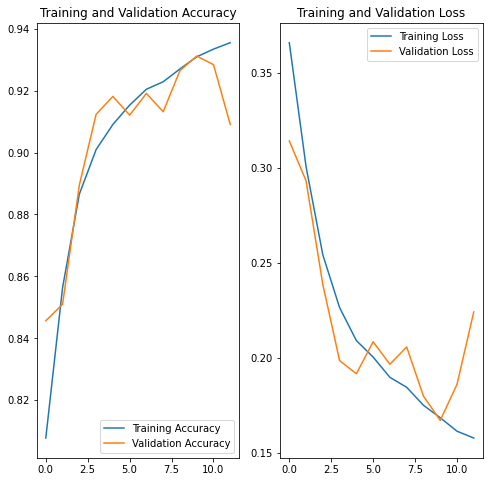

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(callback.stopped_epoch+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Les deux courbes ci-dessus nous rapportent sous forme de graphique les performances de notre modèle:

- `Training and Validation Accuracy`: <div style = "text-align: justify">Cette courbe nous montre l'évolution de la précision de notre modèle par rapport à nos jeux de données d'entraînement et de test. Après analyse des courbes, nous pouvons poser l'hypothèse que notre modèle ne surapprend pas et possède une très bonne précision dans la classification de photo.</div>


- `Training and Validation Loss` : <div style = "text-align: justify"> Pour valider cette hypothèse, nous pouvons nous baser sur le graphique de droit. En effet, cette courbe nous permet de constater l'évolution de la fonction de perte sur les mêmes repères que la courbe précédente. Grace à l'étude de ce graphique, nous pouvons confirmer l'hypothèse formulée après la première analyse.</div>

#### 4.4.4 Transfer learning

<div style = "text-align: justify">Pour minimiser au maximum notre fonction de coût, nous avons décidé d'effectuer une sorte de  <strong>transfer learning</strong>. Cette technique nous permet de repartir des résultats obtenus avec le premier algorithme d'optimisation (Adam) et de continuer l'entraînement avec un nouvel algorithme (RMSprop). Au vu des résultats suivants, nous constatons que la fonction de coût a été minimisée.</div>

-	**Adam** : Cet algorithme d'optimisation est utilisé pour la formation de modèles d'apprentissage profond. Il s'agit d'une extension de la descente de gradient stochastique. 

-	**RMSProp** : Tout comme l'algorithme Adam, RMSProp (Root Mean Square Propagation) est un algorithme d'optimisation qui accélère la descente de gradient, il est utilisé pour entrainer des modèles à base de réseaux de neuronnes profonds.

Nous remarquons que ces deux algorithmes sont assez similaires, c'est pourquoi nous avons décidé d'entrainer notre modèle dans un premier temps avec Adam, puis d'affiner notre entrainement avec RMSProp.

In [23]:
complete_model.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer = keras.optimizers.RMSprop(learning_rate=0.00001),
              metrics=['accuracy'])

fine_tune_epochs = 30
total_epochs = callback.stopped_epoch + fine_tune_epochs
epoch1=callback.stopped_epoch
callback1 = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
with tf.device('/device:GPU:0'):
    history_fine = complete_model.fit(train_set,
                             epochs=total_epochs,
                             initial_epoch=history.epoch[-1],
                             callbacks=[callback1],
                             validation_data=test_set)

Epoch 12/41
1036/1036 [==============================] - 125s 119ms/step - loss: 0.1321 - accuracy: 0.9467 - val_loss: 0.1611 - val_accuracy: 0.9372
Epoch 13/41
1036/1036 [==============================] - 112s 108ms/step - loss: 0.1279 - accuracy: 0.9492 - val_loss: 0.1672 - val_accuracy: 0.9372
Epoch 14/41
1036/1036 [==============================] - 113s 109ms/step - loss: 0.1252 - accuracy: 0.9500 - val_loss: 0.1567 - val_accuracy: 0.9387
Epoch 15/41
1036/1036 [==============================] - 121s 116ms/step - loss: 0.1239 - accuracy: 0.9499 - val_loss: 0.1592 - val_accuracy: 0.9385
Epoch 16/41
1036/1036 [==============================] - 114s 110ms/step - loss: 0.1220 - accuracy: 0.9523 - val_loss: 0.1608 - val_accuracy: 0.9388
Epoch 17/41
1036/1036 [==============================] - 121s 117ms/step - loss: 0.1212 - accuracy: 0.9521 - val_loss: 0.1687 - val_accuracy: 0.9373
Epoch 18/41
1036/1036 [==============================] - 108s 105ms/step - loss: 0.1217 - accuracy: 0.9509

#### 4.4.5 Visualisation des résultats

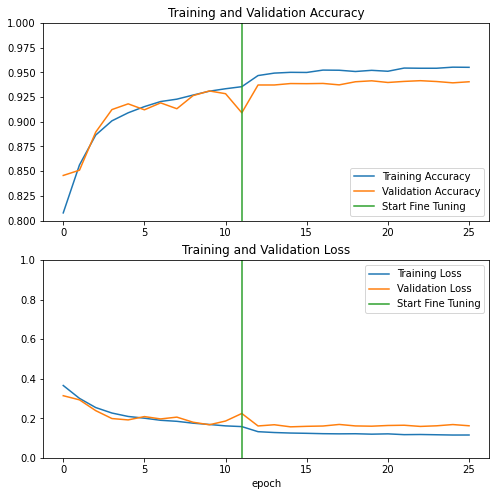

In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([epoch1,epoch1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epoch1,epoch1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 5. Mesure de la performance  <a class="anchor" id="chapter5"></a>

<div style = "text-align: justify">Une fois que nous avons entraîné notre modèle nous devons garantir la bonne classification des éléments. Pour ce faire, nous allons afficher la matrice de confusion. A partir de celle-ci, nous pourrons appliquer différentes métriques qui attesteront de la performance de notre modèle. Pour conclure cette partie nous visualiserons la courbe ROC.</div>

### 5.1 Matrice de confusion <a class="anchor" id="section_5_1"></a>

#### 5.1.1 Définition

<div style = "text-align: justify">La performance d’un algorithme de Machine Learning est directement liée à sa capacité à prédire un résultat. Lorsque l’on cherche à comparer les résultats d’un algorithme à la réalité, on utilise une matrice de confusion. Elle prédit des résultats que l’on doit comparer à la réalité pour mesurer son degré de performance. Pour ce faire, elle mettra non seulement en valeur les prédictions correctes et incorrectes, mais nous donnera surtout un indice sur le type d’erreurs commises.</div>

In [25]:
predictions = complete_model.predict(test_set)
predicted_categories = [1 * (x[0]>=0.5) for x in predictions]
true_categories = tf.concat([y for x, y in test_set], axis=0)

conf_matrix = confusion_matrix(true_categories, predicted_categories)
print(conf_matrix)

[[6103  237]
 [ 256 1685]]


#### 5.1.2 Interprétation des résultats

<div style = "text-align: justify">La matrice générée ci-dessus doit être interprétée de cette manière : </div>

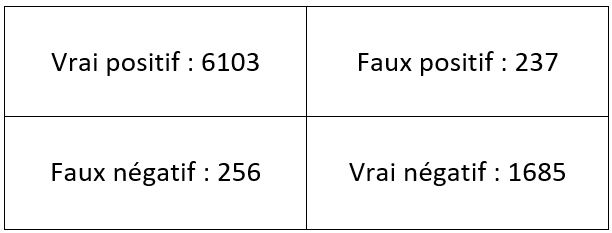
<br>
<div style = "text-align: justify">Dans notre cas, le "vrai positif" correspond au nombre d'éléments de notre dataset de test/validation qui a été correctement classé dans notre dossier "Autre". Réciproquement, le "vrai négatif" correspond aux éléments correctement classés dans notre dossier "Photo". Les deux autres réusultats correspondent aux éléments mal classés. On a donc un taux d'erreur d'environ 10% sur le classement de nos photos, ce qui est très convaincant pour la suite de notre projet.</div>

### 5.2 Précision, Recall, F1 Score <a class="anchor" id="section_5_2"></a>

- `Recall` : Le recall est le rapport entre les observations positives correctement prédites et toutes les observations de la classe réelle.

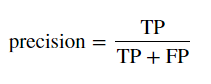

- `Précision`: La précision est le rapport entre les observations positives correctement prédites et le total des observations positives prédites.

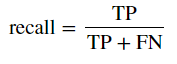

- `F1 Score`: Le score F1 est la moyenne pondérée de la précision et du rappel. Par conséquent, ce score prend en compte à la fois les faux positifs et les faux négatifs.

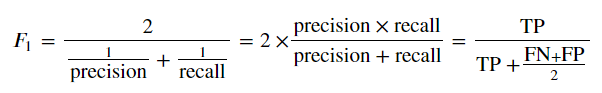

In [26]:
precision_score = precision_score(true_categories, predicted_categories)
recall_score = recall_score(true_categories, predicted_categories)
f1_score = f1_score(true_categories, predicted_categories)

print("Precision score: "+str(precision_score)+" Recall Score: "+str(recall_score)+" F1 Score: "+str(f1_score))

Precision score: 0.8766909469302809 Recall Score: 0.8681092220504895 F1 Score: 0.8723789800673052


### 5.3 Courbe ROC <a class="anchor" id="section_5_3"></a>

On affiche la matrice de confusion calculée sur nos données :

In [27]:
complete_model.evaluate(test_set)

259/259 [==============================] - 5s 17ms/step - loss: 0.1621 - accuracy: 0.9405


[0.16205452382564545, 0.9404661059379578]

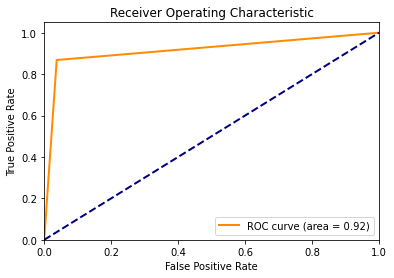

In [28]:
fpr, tpr, _ = roc_curve(true_categories, predicted_categories)

roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

La diagonale en pointillé représente la ROC d'un classificateur aléatoire. Un classificateur idéal s'en écarte au maximum en épousant le coin supérieur gauche.

In [29]:
roc_auc_score(true_categories, predicted_categories)

0.915363759290229

On utilise comme métrique de comparaison l'aire sous la courbe ROC, que l'on souhaite la plus proche possible de 1. On calcule donc le ROC AUC SCORE.
<br>
Nous avons une valeur de 0,92, nous pouvons en conclure que notre classificateur est très proche du classificateur idéal.

## 6. Classification du modèle <a class="anchor" id="chapter6"></a>

Nous sommes maintenant à la fin du processus de création du modèle. En effet, cette partie est orientée sur la sauvegarde du modèle que nous avons entraîné et évalué et aux tris finaux des images.

### 6.1 Sauvegarde du modèle  <a class="anchor" id="section_6_1"></a>

Une fois le modèle entrainé, nous pouvons enregistrer sa configuration et ses poids. Cela nous permettra de réutiliser directement le modèle sans avoir à l'entrainer une nouvelle fois. 

In [30]:
complete_model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


### 6.2 Sauvegarde des résultats de classification du modèle <a class="anchor" id="section_6_2"></a>

Le code ci-dessous crée les dossiers "Photo" et "Autre", où l'on stockera les résultats de prédiction du modèle.

In [31]:
classification_dir = pathlib.Path('Classification')
class_test = ['Photo','Autre']

if os.path.exists(classification_dir) == False:
    os.mkdir(classification_dir)
    class_predict = map(lambda x: os.path.join(classification_dir, x), class_test)
    [os.mkdir(x) for x in class_predict]

La fonction `load_image()` permet de récupérer tous les noms des images que nous voulons classifier.

In [32]:
def load_image():
    #veuillez mettre le chemin d'accès de votre dossier contenant les images à classer dans la variable path_data 
    path_data = "C://Users//jbcst//OneDrive//Bureau//new" 
    onlyfiles = [os.path.join(path_data, f) for f in os.listdir(path_data) if os.path.isfile(os.path.join(path_data, f))]
    return onlyfiles

Pour finir, nous chargeons notre modèle et trions chaque image renvoyée par la fonction `load_image()` puis enregistrons les résultats dans les fichiers associés à la prédiction du modèle ("Photo" ou "Autre").

In [33]:
model_dir = pathlib.Path("saved_model//my_model")

model = keras.models.load_model(model_dir)
count = 0
list_file = load_image()
for file in list_file:
    img = image.load_img(file, target_size=(180, 180))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images)
    if classes[0]<0.5:
        img.save("{path}//{name}.png".format(path = os.path.join(classification_dir, class_test[1]), name = file.split("\\")[1]), format='PNG')
    else:
        img.save("{path}//{name}.png".format(path = os.path.join(classification_dir, class_test[0]), name = file.split("\\")[1]), format='PNG')
    count+=1

### 7. Conclusion  <a class="anchor" id="chapter7"></a>

<div style = "text-align: justify">Dans ce notebook, nous avons, dans un premier temps, configuré notre environnement de développement en y ajoutant les librairies Python vues en cours et en basculant le traitement sur le GPU afin de gagner en performance d'exécution. Nous avons alors pu créer notre dataset en y ajoutant de la data augmentation et de la parallélisation dans le processus d'execution par batch. Une fois notre dataset prêt, nous avons pu implémenter le modèle CNN qui répondait parfaitement à nos contraintes. Dans l'optique d'avoir les meilleurs résultats, nous avons calibré les paramètres de ce modèle par l'intermédiaire du fine tuning. Pour finir, nous avons appliqué différentes métriques de performance pour assurer que la configuration du modèle était la meilleure.</div>

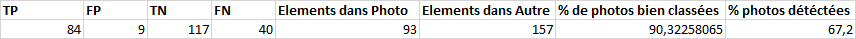
<br>
<strong>Légende :</strong>
- TP : Nombre de photos bien classées
- FP : Nombre de "Autre" classé dans le dossier "Photo"
- TN : Nombre de "Autre" bien classé
- FN : Nombre de photos classées dans le dossier "Autre"

<br>
<div style = "text-align: justify">Ce tableau représente les performances de notre modèle sur un dataset externe téléchargé sur Kaggle. Il se compose uniquement de photos ainsi que de peintures. La classification des autres genres d'images étant acquise et proche de 95%, nous ne pouvons que constater les bonnes performances de notre modèle.</div>